Universidad del Valle de Guatemala - 22/07/2022

Jose Abrahama Gutierrez Corado - 19111 <br>
Walter Danilo Saldaña - 19897 <br>
Javier Alejandro Cotto Argueta -19324


# Laboratorio 1
## Series de tiempo
______________________________________________________


Importar módulos

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns
from multiprocessing import cpu_count
from joblib import delayed

import import_ipynb
from TS import *

## Carga de datos

In [2]:
df = pd.read_csv('./GlobalLandTemperaturesByCountry.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


## 1. Análisis exploratorio

### Descripción del dataset
Representa las temperaturas promedio mensuales, desde 1750, para muchos lugares del mundo. El documento de donde se extrajo la información lo puede encontrar en el siguiente vínculo: http://berkeleyearth.org/data/

### Detalle de las variables

|Variable                      |Detalle|Clasificación|
|:-----------------------------|:------|:------------|
|dt                            |Date time. Mes y año de la medición|Cualitativa ordinal|
|AverageTemperature            |Temperatura promedio en el mes y año indicado por dt|Cuantitativa continua|
|AverageTemperatureUncertainty |Incertidumbre de la medición de temperatura|Cuantitativa continua|
|Country                       |País dónde se realizó la medición|Cualitativa nominal|


### Resúmen estadístico del dataset

In [3]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,1.019057
std,10.953966,1.201930
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.206000
max,38.842000,15.003000


### Limpieza de datos
#### Datos incompletos
Las series de datos que no tienen valor para la variable `AverageTemperature` no aportan información para el análisis, por lo cual se descartan.

In [4]:
df['AverageTemperature'].isnull().sum()

32651

In [5]:
df = df.dropna(subset=['AverageTemperature'])
df['AverageTemperature'].isnull().sum()

0

A fines prácticos se aproximará a 0 la incertidumbre (`AverageTemperatureUncertainty`) de las filas que no tengan información de la misma.

In [6]:
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].fillna(0)
df['AverageTemperatureUncertainty'].isnull().sum()

0

#### Datos atípicos
Se analizan los datos atípicos de la variable `AverageTemperature`.

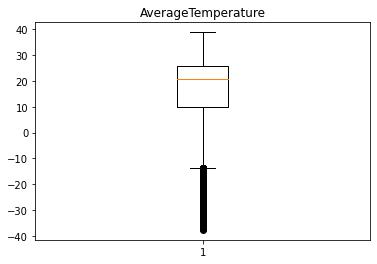

In [7]:
plt.boxplot(df['AverageTemperature'])
plt.title('AverageTemperature')
plt.show()

In [8]:
Q1 = df['AverageTemperature'].quantile(0.25)
Q3 = df['AverageTemperature'].quantile(0.75)
IQR = Q3 - Q1

inferior = df[df['AverageTemperature'] < (Q1 - 1.5 * IQR)]
superior = df[df['AverageTemperature'] > (Q3 + 1.5 * IQR)]

In [9]:
len(inferior)

6438

In [10]:
len(superior)

0

Dada la naturaleza del dataset y al ser medidas climáticas, se espera que los datos atípicos sí aporten información significatica al análisis, por lo que no hay necesidad de eliminarlos.

Se analizan los datos atípicos de la variable `AverageTemperatureUncertainty`.

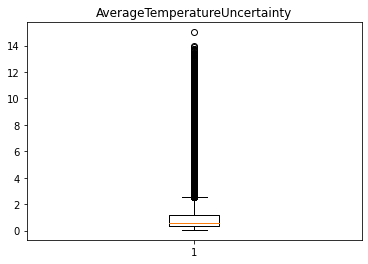

In [11]:
plt.boxplot(df['AverageTemperatureUncertainty'])
plt.title('AverageTemperatureUncertainty')
plt.show()

In [12]:
Q1 = df['AverageTemperatureUncertainty'].quantile(0.25)
Q3 = df['AverageTemperatureUncertainty'].quantile(0.75)
IQR = Q3 - Q1

inferior = df[df['AverageTemperatureUncertainty'] < (Q1 - 1.5 * IQR)]
superior = df[df['AverageTemperatureUncertainty'] > (Q3 + 1.5 * IQR)]

In [13]:
len(inferior)

0

In [14]:
len(superior)

48207

Para el caso de esta variable, si se hace notar la importancia de eliminar los datos atípicos, pues el extremo superior indica que hay varios datos con mediciones muy imprecisas, los cuales pueden distorsionar el análisis.

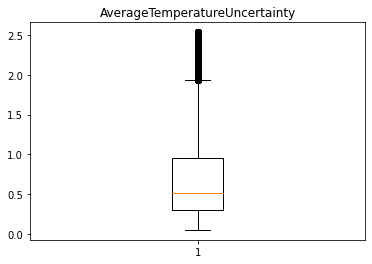

In [15]:
df.drop(superior.index, inplace=True)
    
plt.boxplot(df['AverageTemperatureUncertainty'])
plt.title('AverageTemperatureUncertainty')
plt.show()

### Comportamiento de datos

#### Normalidad de los datos

In [16]:
def show_normality(data):
    mu, std = norm.fit(data)
    plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
  
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()
    
    kurtosis = data.kurtosis()
    skew = data.skew()
    print('Kurtosis: ', kurtosis)
    print('Sesgo: ', skew)

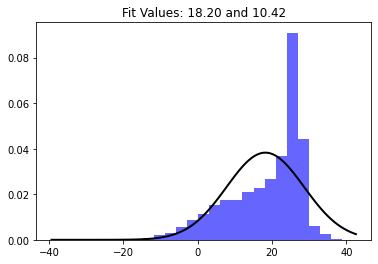

Kurtosis:  1.3855022552328835
Sesgo:  -1.2227423931132673


In [17]:
show_normality(df['AverageTemperature'])

No se puede aproximar la variable de `AverageTemperature` a una distribución normal.

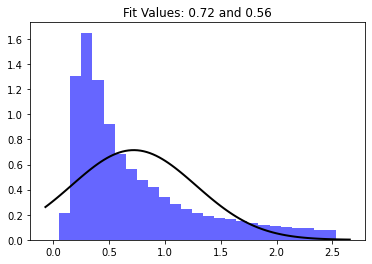

Kurtosis:  1.0329705116182009
Sesgo:  1.3416322002714294


In [18]:
show_normality(df['AverageTemperatureUncertainty'])

La variable de `AverageTemperatureUncertainty` tampoco cumple para una distribución normal.

#### Correlación de los datos

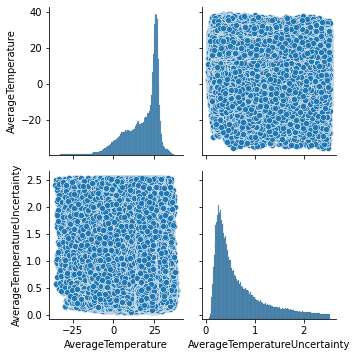

In [19]:
sns.pairplot(data=df)

<AxesSubplot:>

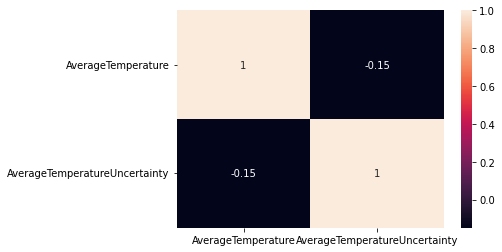

In [22]:
correlacion = df[['AverageTemperature', 'AverageTemperatureUncertainty']].corr()
fig, axis = plt.subplots()
sns.heatmap(correlacion, xticklabels=correlacion.columns, yticklabels=correlacion.columns, annot=True, ax=axis)

Se puede observar que no hay correlación entre las variables númericas estudiadas.

#### Lugares con temperaturas más extremas

In [23]:
avg_temp_by_country = df.groupby('Country').mean()\
    .sort_values(by=['AverageTemperature'])

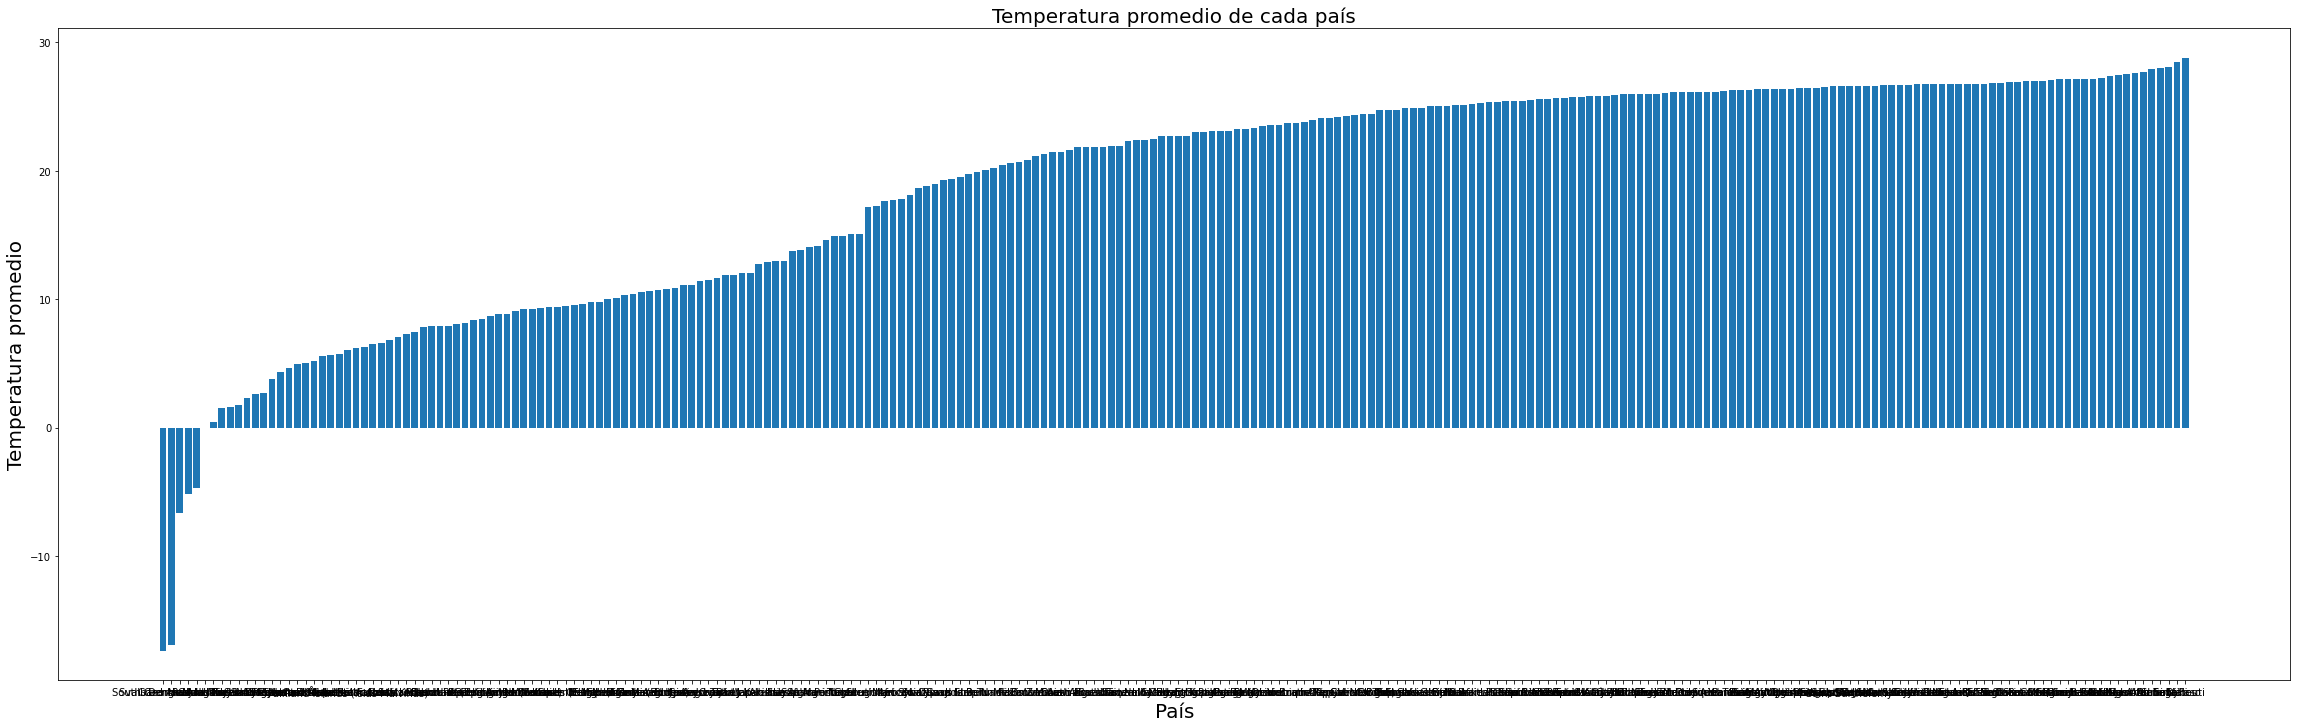

In [24]:
plt.figure(figsize=(40,12))
plt.bar(
    avg_temp_by_country.index,
    avg_temp_by_country['AverageTemperature']
)
plt.title('Temperatura promedio de cada país', size=20)
plt.xlabel('País', size=20)
plt.ylabel('Temperatura promedio', size=20)
plt.show()

Top 5 lugares con temperaturas más bajas:

In [25]:
avg_temp_by_country.head()

,AverageTemperature,AverageTemperatureUncertainty
Country,,
Greenland,-17.382228,1.251991
Denmark,-16.928744,1.227067
Svalbard And Jan Mayen,-6.653556,1.072731
Russia,-5.179728,0.890896
Canada,-4.682512,0.943881


Top 5 lugares con temperaturas más altas:

In [26]:
avg_temp_by_country.tail()

,AverageTemperature,AverageTemperatureUncertainty
Country,,
Aruba,27.924171,0.633795
Senegal,27.984304,0.672733
Burkina Faso,28.085516,0.694007
Mali,28.444861,0.772745
Djibouti,28.815201,0.860161


De lo más destacable en este punto es que los países más calurosos no difieren de forma extrema a la temperatura promedio del resto de países. Por el otro lado, los países más frios son más escasos, y con temperaturas más extremas en comparación a los demás.

## 2. Serie univariante por la variable AverageTemperature

### a. Especifique Inicio, fin, y frecuencia.

- **Inicio**: Año 2000, debido a que conocemos que en los últimos años la temperatura ha incremendado a un ritmo sin precedentes, por lo que la información de años anteriores ya no resulta muy útil.
- **Fin**: 2013 (año más reciente con datos disponibles)
- **Frecuencia**: Mensual

In [27]:
temp_serie = df[['dt', 'AverageTemperature']]\
    .loc[df['dt'] > '2000']
temp_serie

,dt,AverageTemperature
3074,2000-01-01,0.197
3075,2000-02-01,-0.023
3076,2000-03-01,0.615
3077,2000-04-01,4.124
3078,2000-05-01,8.557
...,...,...
577456,2013-04-01,21.142
577457,2013-05-01,19.059
577458,2013-06-01,17.613
577459,2013-07-01,17.000


### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

In [28]:
temp_serie = temp_serie[['dt', 'AverageTemperature']].groupby('dt').mean()\
    .sort_values(by=['AverageTemperature'])

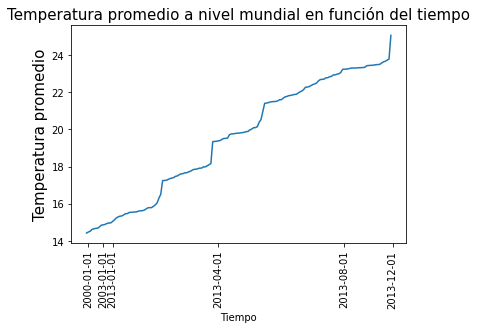

In [29]:
plt.plot(
    temp_serie.index,
    temp_serie['AverageTemperature']
)
plt.title('Temperatura promedio a nivel mundial en función del tiempo', size=15)
plt.xlabel('Tiempo')
plt.ylabel('Temperatura promedio', size=15)
plt.xticks(
    ['2000-01-01', '2003-01-01', '2013-01-01', '2013-04-01', '2013-08-01', '2013-12-01'],
    rotation=90
)
plt.show()

Hay dos hallazgos notables, en primer lugar el se ve un aumento pronunciado de la temperatura global con el paso del tiempo. En segundo lugar, se observa que en los últimos años la temperatura ha aumentado desmesuradamente, con un comportamiento que parece ser incluso exponencial.

### c. Descomponga la serie en sus componentes. Teniendo en cuenta el diagrama de la serie y sus componentes discuta si es posible hablar de estacionalidad.

No se puede observar estacionalidad, pues no se identifican patrones que se repitan año tras año. De los componentes que se observan, se puede notar que la serie de datos tiene una tendencia a crecer.

### d. Determine si es necesario transformar la serie. Explique.

Dado que no se encontró estacionalidad en los datos, es válido suponer que es necesario transformar la serie, sin embargo, dadas las suposiciones del análisis exploratorio y conocimientos generales, se sabe que la temperatura global en los últimos años ha aumentado significativamente cambiando patrones naturales habituales. Por lo tanto, la serie de datos actual cumple con dichas suposiciones,por lo que no requiere transformación.

### e. Una   vez   analizada   la   serie,   elija   los  parámetros   p,   q   y   d   del   modelo   ARIMA   o SARIMA 

In [30]:
p = 1
q = 1
d = 0 # ya es estacionaria

### f. Haga varios modelos SARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie.

Se utilizará ARIMA dado que no se encontró estacionalidad en los datos.

Tamaño Entrenamiento 132
Tamaño Prueba 33
Encontrando la mejor solución para promedio
 > Modelo[1, 'mediana'] 0.227 > Modelo[1, 'promedio'] 0.227 > Modelo[2, 'mediana'] 0.235 > Modelo[2, 'promedio'] 0.235 > Modelo[3, 'mediana'] 0.246 > Modelo[3, 'promedio'] 0.246



 > Modelo[4, 'promedio'] 0.255
 > Modelo[5, 'mediana'] 0.265 > Modelo[4, 'mediana'] 0.255 > Modelo[6, 'mediana'] 0.274 > Modelo[7, 'mediana'] 0.284
 > Modelo[5, 'promedio'] 0.265
 > Modelo[6, 'promedio'] 0.274
 > Modelo[7, 'promedio'] 0.284


 > Modelo[8, 'mediana'] 0.295


 > Modelo[8, 'promedio'] 0.295 > Modelo[9, 'promedio'] 0.307
 > Modelo[9, 'mediana'] 0.307
 > Modelo[10, 'mediana'] 0.319


 > Modelo[11, 'mediana'] 0.332 > Modelo[12, 'promedio'] 0.340 > Modelo[11, 'promedio'] 0.332 > Modelo[12, 'mediana'] 0.340

 > Modelo[13, 'mediana'] 0.349

 > Modelo[14, 'mediana'] 0.359 > Modelo[15, 'mediana'] 0.370 > Modelo[16, 'mediana'] 0.381
 > Modelo[10, 'promedio'] 0.319
 > Modelo[17, 'mediana'] 0.394
 > Modelo[19, 'mediana']

 > Modelo[112, 'promedio'] 2.885 > Modelo[128, 'mediana'] 3.400

 > Modelo[131, 'promedio'] 3.556 > Modelo[124, 'promedio'] 3.261

 > Modelo[120, 'promedio'] 3.138
 > Modelo[128, 'promedio'] 3.400 > Modelo[132, 'mediana'] 3.605

 > Modelo[132, 'promedio'] 3.605
terminado
[1, 'mediana'] 0.22681809249026863
[1, 'promedio'] 0.22681809249026863
[2, 'mediana'] 0.2352769336198798


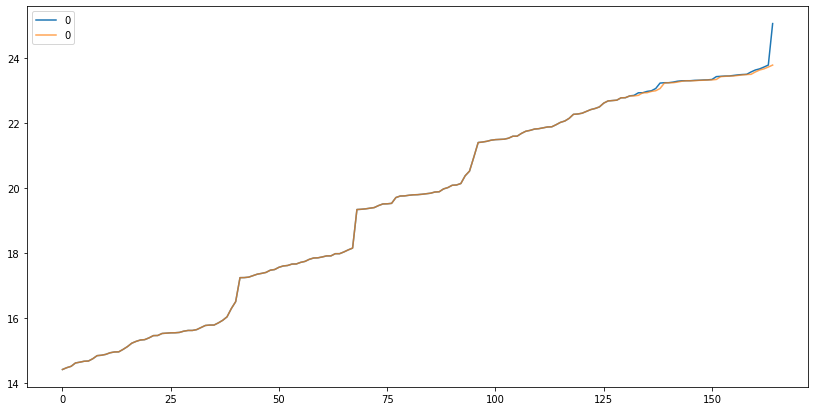

In [55]:
encontrar_mejor_solucion(temp_serie, 'TS Temperatura', metodo = "promedio")

### g. Haga un modelo usando el algoritmo Prophet de Facebook. Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?